In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader# for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torch.utils.data import random_split
%matplotlib inline



### Dataset Loading and Data Preparation
In this section, we define a custom dataset class to handle image loading. By organizing the images in subdirectories named after their respective classes, we create an efficient way to load data based on the folder structure. The `CustomImageDataset` class processes images and their corresponding labels, allowing us to easily access and transform them during training. We also ensure that the images are loaded with proper transformations, such as resizing, tensor conversion, and normalization, making the dataset ready for model input.

Additionally, we split the dataset into training and validation sets. The training set will consist of 80% of the data, while 20% will be used for validation. We then use DataLoader to batch the data and shuffle it during training for better model performance. With these steps, we ensure that the model receives well-prepared data for both training and evaluation.


In [2]:
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image

# Define a custom Dataset class for loading images from directories.
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initialize the dataset.

        Args:
            root_dir (str): The directory where images are stored in subdirectories named by class.
            transform (callable, optional): A function/transform to apply to each image.
        """
        self.root_dir = root_dir  # Store the root directory path.
        self.transform = transform  # Store the transform to be applied to images.
        self.images = []  # List to hold file paths of the images.
        self.labels = []  # List to hold the corresponding class labels.

        # Initialize a set to keep track of unique class names.
        self.classes = set()

        # Loop through each directory in the root directory.
        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)  # Get the path to the class directory.
            if os.path.isdir(class_dir):  # Check if it is indeed a directory.
                self.classes.add(label)  # Add the class name to the set.
                # Loop through each image in the class directory.
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)  # Get the full image path.
                    self.images.append(img_path)  # Store the image path.
                    self.labels.append(label)  # Store the corresponding label.

        # Create a mapping from class names to integer indices.
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        """
        Return the total number of images in the dataset.

        Returns:
            int: Total number of images.
        """
        return len(self.images)  # Return the length of the images list.

    def __getitem__(self, idx):
        """
        Retrieve an image and its label by index.

        Args:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: (image, label) where image is a transformed tensor and label is an integer.
        """
        img_path = self.images[idx]  # Get the image path.
        label = self.class_to_idx[self.labels[idx]]  # Get the label index.

        image = Image.open(img_path).convert('RGB')  # Open the image and convert to RGB.

        if self.transform:  # Check if a transform is provided.
            image = self.transform(image)  # Apply the transform to the image.

        return image, label  # Return the transformed image and its label.

# Define transformations for data augmentation and normalization.
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 pixels.
    transforms.ToTensor(),            # Convert images to PyTorch tensors.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std.
])

# Set the root directory where class folders are located.
root_dir = '/kaggle/input/data'  # Update this path to your actual image directory.

# Create an instance of the custom dataset.
dataset = CustomImageDataset(root_dir=root_dir, transform=transform)

# Access the classes and number of classes.
num_classes = len(dataset.classes)  # Get the total number of unique classes.
classes = dataset.classes  # Retrieve the set of class names.

# Split the dataset into training and validation sets (80% training, 20% validation).
train_size = int(0.8 * len(dataset))  # Calculate the size of the training set.
val_size = len(dataset) - train_size   # Calculate the size of the validation set.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  # Split the dataset.

# Create data loaders for training and validation datasets.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # DataLoader for training set, shuffling the data.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)      # DataLoader for validation set, no shuffling.

# Define a function to calculate accuracy of model predictions.
def accuracy(outputs, labels):
    """
    Calculate the accuracy of model predictions.

    Args:
        outputs (torch.Tensor): The model's output logits.
        labels (torch.Tensor): The ground truth labels.

    Returns:
        float: The accuracy as a percentage.
    """
    _, preds = torch.max(outputs, dim=1)  # Get the predicted class indices.
    return torch.sum(preds == labels).item() / len(preds)  # Calculate and return accuracy.

# Define the evaluate function for model validation.
@torch.no_grad()  # Disable gradient calculation for evaluation.
def evaluate(model, val_loader, device):
    """
    Evaluate the model performance on the validation dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        val_loader (DataLoader): DataLoader for the validation dataset.
        device (torch.device): The device (CPU or GPU) to perform evaluation on.

    Returns:
        dict: A dictionary containing average loss and accuracy across all batches.
    """
    model.eval()  # Set the model to evaluation mode.
    val_losses, val_correct = [], 0  # Initialize loss and accuracy accumulators.
    
    # Iterate through the validation DataLoader.
    for batch in val_loader:
        images, labels = batch  # Retrieve images and labels from the batch.
        images, labels = images.to(device), labels.to(device)  # Move images and labels to device.
        
        out = model(images)  # Perform a forward pass to get model predictions.
        
        # Ensure labels are long tensors for compatibility with loss function.
        labels = labels.long()  # Convert labels to long tensor if necessary.

        # Compute cross-entropy loss between model outputs and true labels.
        loss = F.cross_entropy(out, labels)  # Calculate loss.
        acc = accuracy(out, labels)  # Calculate accuracy for current batch.

        val_losses.append(loss.item())  # Accumulate batch loss.
        val_correct += acc * len(labels)  # Accumulate batch accuracy.

    # Calculate mean loss and overall accuracy.
    avg_loss = np.mean(val_losses)
    avg_accuracy = val_correct / len(val_loader.dataset)
    
    return avg_loss,avg_accuracy


After implementing the dataset class and setting up the data loaders, we can move on to the training process. By splitting the dataset into training and validation sets, we ensure that our model can be properly evaluated on unseen data during training. The DataLoader allows us to efficiently manage batches of data, making training smoother and faster.

Next, we implement functions for evaluating the model's performance. The `accuracy` function helps us measure how well the model is performing by comparing predictions to actual labels, while the `evaluate` function handles the evaluation on the validation dataset. These metrics will guide us in assessing the effectiveness of our model during training and fine-tuning. 


We  will then view the classes and the dataset 

In [3]:
print("\n".join(sorted(classes)))  # Sorted for better readability


Apple___alternaria_leaf_spot
Apple___black_rot
Apple___brown_spot
Apple___gray_spot
Apple___healthy
Apple___rust
Apple___scab
Bell_pepper___bacterial_spot
Bell_pepper___healthy
Blueberry___healthy
Cassava___bacterial_blight
Cassava___brown_streak_disease
Cassava___green_mottle
Cassava___healthy
Cassava___mosaic_disease
Cherry___healthy
Cherry___powdery_mildew
Corn___common_rust
Corn___gray_leaf_spot
Corn___healthy
Corn___northern_leaf_blight
Grape___Leaf_blight
Grape___black_measles
Grape___black_rot
Grape___healthy
Grape___leaf_blight
Orange___citrus_greening
Peach___bacterial_spot
Peach___healthy
Potato___bacterial_wilt
Potato___early_blight
Potato___healthy
Potato___late_blight
Potato___nematode
Potato___pests
Potato___phytophthora
Potato___virus
Raspberry___healthy
Rice___bacterial_blight
Rice___blast
Rice___brown_spot
Rice___tungro
Soybean___healthy
Squash___powdery_mildew
Strawberry___healthy
Strawberry___leaf_scorch
Sugercane___healthy
Sugercane___mosaic
Sugercane___red_rot
Suge

In [4]:
print(f' Number of images is  :{len(dataset)}   ,   Number of Classes is : {len(classes)}')

 Number of images is  :97296   ,   Number of Classes is : 61


In [5]:
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")


Training samples: 77836
Validation samples: 19460


We will now display a set of images from our dataset in a clear, visual way, . The `imshow` function does most of the work: it takes an image that’s been normalized (its pixel values set between -1 and 1) and adjusts it back to a standard 0 to 1 range, so it looks normal when shown. Afterward, the image format is adjusted so it displays correctly with Matplotlib.

The code then gets a batch of images and labels from the `train_loader`, which is a data source for training images. The labels are mapped to actual class names, so when displayed, each image shows the correct label rather than just a number.

In the final part, the code creates a 3x3 grid to show nine images from the batch, each with its class name displayed above it. This grid setup provides an easy way to check if the data is loaded correctly and if the labels match the images, a handy check before diving into model training.

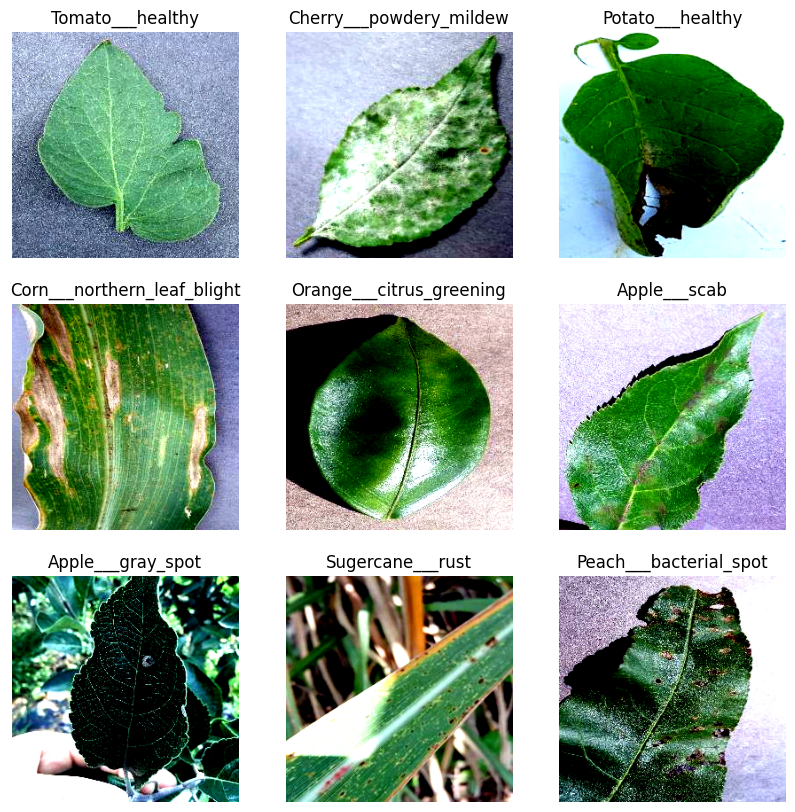

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to denormalize and display images
def imshow(img):
    """
    Denormalize and display an image.

    Args:
        img (torch.Tensor): The input image tensor normalized to [-1, 1].
    """
    img = img / 2 + 0.5  # Unnormalize the image from [-1, 1] to [0, 1]
    npimg = img.numpy()  # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose the array to (H, W, C)
    plt.axis('off')  # Hide the axis

# Get a batch of training data from the DataLoader
data_iter = iter(train_loader)  # Create an iterator for the training data
images, labels = next(data_iter)  # Get the first batch of images and labels

# Reverse the class mapping to get a list of class names
class_names = {v: k for k, v in dataset.class_to_idx.items()}

# Display a grid of images
plt.figure(figsize=(10, 10))  # Set the figure size
for idx in range(9):  # Show the first 9 images
    plt.subplot(3, 3, idx + 1)  # Create a subplot grid of 3 rows and 3 columns
    imshow(images[idx])  # Display the image
    plt.title(class_names[labels[idx].item()])  # Show class name as title, converting label to item
plt.show()  # Render the plot


### Model Engineering

We’ll kick things off by building a simple neural network block. This block consists of two convolutional layers, each followed by batch normalization and ReLU activation. To add depth, we incorporate residual connections by adding the input to the output after the second convolution.

In [7]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolution layer with Batch Normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()

        # Second convolution layer with Batch Normalization and ReLU activation
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        # Pass the input through the first conv layer, batch norm, and ReLU activation
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        # Pass the result through the second conv layer, batch norm, and add residual connection
        out = self.conv2(out)
        out = self.bn2(out)

        # Adding input to the output (residual connection)
        out += x

        # Apply ReLU activation to the final output
        return self.relu2(out)


##### Focal Loss
We use the FocalLoss function because it helps the model focus on harder examples that are often misclassified, especially in imbalanced datasets. The alpha parameter helps adjust the focus on positive examples, while gamma reduces the loss for well-classified cases, forcing the model to concentrate on the challenging ones. This loss function ultimately aims to improve the model’s performance by preventing it from being overwhelmed by easier examples or a dominant class.

##### ImageClassificationBase Class
I created the ImageClassificationBase class to organize key training and validation functions in one place, making it reusable across various classification models.

* Training and Validation Steps: The training_step and validation_step methods allow me to define specific actions the model should take during each phase. Here, I calculate loss (with Focal Loss in training) and track validation accuracy, which gives me feedback on model performance and training progress.

* Epoch-End Summaries: To monitor the model’s learning, we implemen epoch_end and validation_epoch_end, which provide aggregated statistics on loss and accuracy after each epoch. It gives me a clear picture of how well the model is doing over time.

* Accuracy Calculation: I use a static method to compute accuracy by comparing predicted and true labels, which helps me quickly understand how well the model performs without manually calculating this each time.

* Model Saving: I added a method to save the model’s state at a specified epoch to allow me to resume training later if needed, or to use a trained version without retraining from scratch.

* Gradient Tracking: track_gradients lets me monitor gradient values for debugging, particularly to identify potential issues like exploding gradients that might arise in deeper models.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Focal loss function, which gives more focus to hard-to-classify examples.
    Arguments:
        alpha (float): Weighting factor for positive examples.
        gamma (float): Focusing parameter to reduce the relative loss for well-classified examples.
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, outputs, targets):
        # Calculate the cross-entropy loss without reducing it to allow per-example weighting
        cross_entropy_loss = F.cross_entropy(outputs, targets, reduction='none')
        # Compute the probability of the correct class
        pt = torch.exp(-cross_entropy_loss)
        # Calculate focal loss
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * cross_entropy_loss
        return focal_loss.mean()

class ImageClassificationBase(nn.Module):
    """
    Base class for image classification models with training and validation steps,
    loss calculation, accuracy calculation, and performance summaries after each epoch.
    This class is structured for flexible use with any compatible model architecture.
    """

    def __init__(self):
        super().__init__()
        
        # Initialize focal loss
        self.criterion = FocalLoss(alpha=1, gamma=2)
        # Set device attribute based on availability of CUDA
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def training_step(self, batch):
        """
        Executes a single training step, including a forward pass and loss computation.
        Arguments:
            batch (tuple): A batch containing a tensor of images and their corresponding labels.
        Returns:
            torch.Tensor: Focal loss for the batch.
        """
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)  # Move data to the correct device
        out = self(images)  # Forward pass: model predictions
        loss = self.criterion(out, labels)  # Focal loss between predictions and true labels
        return loss

    def validation_step(self, batch):
        """
        Executes a single validation step, including a forward pass, loss computation,
        and accuracy measurement.
        Arguments:
            batch (tuple): A batch containing images and labels.
        Returns:
            dict: Dictionary with validation loss and accuracy for the batch.
        """
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)  # Move data to the correct device
        out = self(images)  # Forward pass
        loss = F.cross_entropy(out, labels)  # Validation loss
        acc = self.accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        """
        Aggregates and averages validation metrics (loss and accuracy) for the epoch.
        Arguments:
            outputs (list): List of dictionaries with val_loss and val_accuracy for each batch.
        Returns:
            dict: Aggregated validation loss and accuracy across all batches in the epoch.
        """
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracies = [x["val_accuracy"] for x in outputs]

        # Stack tensors and compute the mean across batches to get epoch-level metrics
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracies).mean()

        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

    def epoch_end(self, epoch, result):
        """
        Prints the summary of training and validation metrics at the end of each epoch.
        Arguments:
            epoch (int): Current epoch number.
            result (dict): Contains metrics including learning rate, train loss, validation loss, and accuracy.
        """
        print(f"Epoch [{epoch}], last_lr: {result['lrs'][-1]:.5f}, "
              f"train_loss: {result['train_loss']:.4f}, "
              f"val_loss: {result['val_loss']:.4f}, "
              f"val_acc: {result['val_accuracy']:.4f}")

    @staticmethod
    def accuracy(outputs, labels):
        """
        Calculates accuracy by comparing predicted labels to actual labels.
        Arguments:
            outputs (torch.Tensor): Model's predictions for the batch.
            labels (torch.Tensor): Actual labels for the batch.
        Returns:
            torch.Tensor: Computed accuracy for the batch as a scalar tensor.
        """
        # Obtain predicted labels by finding the index of max log-probability per sample
        _, preds = torch.max(outputs, dim=1)
        # Calculate the ratio of correct predictions by comparing preds to labels
        return torch.tensor((preds == labels).float().mean()).to(labels.device)

    def save_model(self, epoch):
        """
        Saves the model's state_dict at a given epoch for future use or recovery.
        Arguments:
            epoch (int): The epoch number at which the model is being saved.
        """
        torch.save(self.state_dict(), f"model_epoch_{epoch}.pth")

    def track_gradients(self, batch):
        """
        Analyzes and prints gradient statistics for debugging and monitoring during training.
        Arguments:
            batch (tuple): A batch containing images and labels.
        """
        self.zero_grad()  # Reset gradients to prevent accumulation
        loss = self.training_step(batch)  # Calculate loss
        loss.backward()  # Compute gradients with backpropagation
        # Print max gradient value for each parameter, useful for debugging exploding gradients
        for name, param in self.named_parameters():
            if param.requires_grad:
                print(f"{name} max grad: {param.grad.abs().max().item()}")


next up we define a neural network model `ResNet34`,  custom version of the ResNet architecture used for image classification tasks, particularly designed to classify images based on disease indicators.

The ConvBlock function creates a basic building block for the network. Each block consists of a convolutional layer (which learns to detect patterns in the images), batch normalization (to stabilize and speed up training), and a ReLU activation (to add non-linearity). Optionally, a max-pooling layer can be added to downsample the image representation, helping the model focus on key features.

The ResNet9 class builds the model structure. It uses multiple ConvBlock layers for feature extraction and includes two residual blocks (res1 and res2). These residual blocks allow the model to retain key feature information by "skipping" connections, which help preserve details and improve learning.

After going through all the convolutional layers, the output is passed through a final classifier. This classifier uses adaptive average pooling to reduce the feature maps to a single value per channel, then flattens them, applies dropout to prevent overfitting, and ends with a fully connected layer that outputs the final predictions for each disease class.

In short, this setup allows ResNet9 to effectively learn hierarchical and complex patterns in medical images, making it a streamlined yet powerful model for disease classification tasks.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# EfficientNet block with depthwise-separable convolution, batch normalization, and squeeze-and-excitation
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor, stride):
        """
        Initializes an MBConvBlock with depthwise separable convolution,
        batch normalization, and squeeze-and-excitation.

        Arguments:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            expansion_factor (int): Factor for expanding the input channels.
            stride (int): Stride for downsampling if needed.
        """
        super().__init__()
        mid_channels = in_channels * expansion_factor
        self.use_residual = (in_channels == out_channels) and (stride == 1)

        # Expansion phase
        self.expand_conv = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        # Depthwise convolution
        self.dw_conv = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        # Squeeze and Excitation
        self.se_reduce = nn.Conv2d(mid_channels, mid_channels // 4, kernel_size=1)
        self.se_expand = nn.Conv2d(mid_channels // 4, mid_channels, kernel_size=1)

        # Output phase
        self.project_conv = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.expand_conv(x)))
        out = F.relu(self.bn2(self.dw_conv(out)))

        # Squeeze-and-excitation
        se = torch.mean(out, dim=(2, 3), keepdim=True)
        se = torch.sigmoid(self.se_expand(F.relu(self.se_reduce(se))))
        out = out * se  # Scale with the SE block output

        out = self.bn3(self.project_conv(out))
        if self.use_residual:
            out = x + out
        return out


class EfficientNetMini(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        """
        EfficientNet-inspired architecture for image classification.

        Arguments:
            num_classes (int): Number of output classes.
            in_channels (int): Number of input channels (default: 3 for RGB).
        """
        super().__init__()
        self.stem_conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(32)

        # Define a few MBConv blocks with increasing channels
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, expansion_factor=1, stride=1),
            MBConvBlock(16, 24, expansion_factor=6, stride=2),
            MBConvBlock(24, 40, expansion_factor=6, stride=2),
            MBConvBlock(40, 80, expansion_factor=6, stride=2),
            MBConvBlock(80, 112, expansion_factor=6, stride=1),
            MBConvBlock(112, 192, expansion_factor=6, stride=2),
            MBConvBlock(192, 320, expansion_factor=6, stride=1)
        )

        # Head layers
        self.head_conv = nn.Conv2d(320, 1280, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(1280)
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        out = F.relu(self.bn0(self.stem_conv(x)))
        out = self.blocks(out)
        out = F.relu(self.bn1(self.head_conv(out)))
        out = F.adaptive_avg_pool2d(out, 1).squeeze()  # Global average pooling
        out = self.classifier(out)
        return out


In [30]:
import torch
import torch.nn as nn

# Convolutional block with Batch Normalization and optional pooling
def ConvBlock(in_channels, out_channels, pool=False, kernel_size=3):
    """
    Creates a convolutional block consisting of a convolutional layer,
    batch normalization, and ReLU activation. Optionally includes a max pooling layer.
    
    Arguments:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        pool (bool): If True, adds a max pooling layer after the convolution.
        kernel_size (int): Size of the convolutional kernel. Default is 3.
        
    Returns:
        nn.Sequential: A sequential container with the convolutional block.
    """
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolution layer with dynamic padding
        nn.BatchNorm2d(out_channels),  # Batch normalization layer for stability and faster convergence
        nn.ReLU(inplace=True)  # ReLU activation for non-linearity
    ]
    if pool:
        layers.append(nn.MaxPool2d(4))  # Add max pooling if specified to downsample feature maps
    return nn.Sequential(*layers)  # Return the composed layers as a sequential model

# ResNet9 architecture class
class ResNet9(ImageClassificationBase):
    """
    ResNet9 model for image classification. Inherits from the base class
    for image classification, providing specific architecture for ResNet9.
    """

    def __init__(self, in_channels, num_diseases):
        """
        Initializes the ResNet9 architecture.
        
        Arguments:
            in_channels (int): Number of input channels (e.g., RGB channels).
            num_diseases (int): Number of output classes (diseases).
        """
        super().__init__()  # Initialize the base class
        
        # Define the layers of the network
        self.conv1 = ConvBlock(in_channels, 64)  
        self.conv2 = ConvBlock(64, 128, pool=True)  # Second block with pooling
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))  # Residual block 1 for deeper feature extraction
        
        self.conv3 = ConvBlock(128, 256, pool=True)  # Third block with pooling
        self.conv4 = ConvBlock(256, 512, pool=True)  # Fourth block with pooling
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))  # Residual block 2 for deeper features
        
        # Final classifier layers
        self.classifier = nn.Sequential( 
            nn.MaxPool2d(4),
            nn.Flatten(),  # Flatten the output for the fully connected layer
            nn.Linear(512, num_diseases)  # Fully connected layer to output classes
        )
        
    def forward(self, xb):
        """
        Forward pass through the network.
        
        Arguments:
            xb (torch.Tensor): Input batch of images.
        
        Returns:
            torch.Tensor: Output predictions for the input batch.
        """
        out = self.conv1(xb)  # Pass input through first convolution block
        out = self.conv2(out)  # Pass through second block
        out = self.res1(out) + out  # Add residual connection for block 1 to keep feature information
        out = self.conv3(out)  # Pass through third block
        out = self.conv4(out)  # Pass through fourth block
        out = self.res2(out) + out  # Add residual connection for block 2 to keep feature information
        out = self.classifier(out)  # Pass through the classifier for final predictions
        return out  # Return the final output predictions


Device Setup:


* Checks for available GPUs with torch.cuda.device_count() to assign resources.
* Sets device to a list of GPU devices if available, or defaults to the CPU.


`to_device Function:`
* Moves data (model, tensors) to the specified device(s).

  
Supports:
* Single device (e.g., one GPU or CPU): moves data directly to it.
* Multiple devices (multi-GPU setup): uses DataParallel for model parallelization, running across multiple GPUs.
  
Model Setup:

Retrieves the number of output classes from train_dataset to define the model’s final layer.
Creates a ResNet9 instance with three input channels and moves it to the selected device(s) for efficient training.

In [10]:
import torch
import torch.nn as nn

# Function to move a tensor, model, or a collection of tensors/models to the specified device(s)
def to_device(data, device):
    """
    Moves a tensor, model, or a collection of tensors/models to the specified device.

    Arguments:
        data (torch.Tensor, nn.Module, list, or tuple): The data or model to be moved.
        device (torch.device or list of torch.device): Target device(s) to move data to.
            Can be a single device (e.g., "cuda") or a list of devices for multi-GPU setups.

    Returns:
        The input data/model moved to the specified device(s).
    """
    # Check if input is a list or tuple to handle collections (e.g., batches of tensors)
    if isinstance(data, (list, tuple)):
        # If data is a collection, recursively move each element to the device
        return [to_device(x, device) for x in data]

    if isinstance(device, list) and len(device) > 1:
        # If we have multiple GPUs, use DataParallel
        if isinstance(data, nn.Module):
            return nn.DataParallel(data, device_ids=device).to(device[0])  # Move model to primary GPU
        else:
            return data.to(device[0])  # Move tensor to primary device
    return data.to(device[0] if isinstance(device, list) else device)  # Handle single device

# Detect if multiple GPUs are available and set the device(s) accordingly
device = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())] if torch.cuda.is_available() else torch.device('cpu')

# Number of classes derived from the training dataset
num_classes = len(train_dataset.dataset.classes)  # Obtain the number of unique classes from the original dataset

# Create the model
model = EfficientNetMini(num_classes)

# Move model to the designated device(s)
model = to_device(model, device)  # Instantiate and move the model to the selected device(s)


In [11]:
from torchinfo import summary

# the model summary
summary(model, input_size=(1, 3, 256, 256))  # Specify batch size as 1


Layer (type:depth-idx)                   Output Shape              Param #
EfficientNetMini                         [61]                      --
├─Conv2d: 1-1                            [1, 32, 128, 128]         864
├─BatchNorm2d: 1-2                       [1, 32, 128, 128]         64
├─Sequential: 1-3                        [1, 320, 8, 8]            --
│    └─MBConvBlock: 2-1                  [1, 16, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 32, 128, 128]         1,024
│    │    └─BatchNorm2d: 3-2             [1, 32, 128, 128]         64
│    │    └─Conv2d: 3-3                  [1, 32, 128, 128]         288
│    │    └─BatchNorm2d: 3-4             [1, 32, 128, 128]         64
│    │    └─Conv2d: 3-5                  [1, 8, 1, 1]              264
│    │    └─Conv2d: 3-6                  [1, 32, 1, 1]             288
│    │    └─Conv2d: 3-7                  [1, 16, 128, 128]         512
│    │    └─BatchNorm2d: 3-8             [1, 16, 128, 128]         32
│    └─

The `fit_OneCycle` is mainly used to make training smooth, fast, and efficient by combining a few  techniques. Here’s a breakdown:

* One-Cycle Learning Rate: We’re using a learning rate schedule that starts low, peaks, and then winds down by the end of training. This pattern encourages the model to explore well early on, then fine-tune as the training progresses, which can lead to faster convergence and better generalization.

* Mixed Precision Training: With autocast and GradScaler, we can use lower precision (float16) for some calculations, saving memory and speeding up training on GPUs. This gives us a performance boost without a loss in accuracy, especially for large datasets and models.

* Gradient Clipping: Sometimes, gradients can get too large, which can destabilize training. Here, gradient clipping keeps them in check, helping ensure that updates are smooth and avoiding any abrupt jumps that could lead to poor results.

##### How It Works

* Each epoch trains on all batches, using the model to make predictions and then computing the loss. We backpropagate to update the model, carefully scale the gradients for stability, and then apply the one-cycle learning rate schedule to keep training effective. We also track metrics for each epoch to monitor the model’s progress as we go.

This setup helps the model learn efficiently and stably from start to finish.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Ensure the model is moved to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# In your fit_OneCycle function, ensure that the inputs and labels are also on the same device
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, grad_clip=None, weight_decay=1e-4, opt_func=optim.SGD):
    # Empty the GPU memory cache to free up any unused memory
    torch.cuda.empty_cache()
    
    # Initialize an empty list to store training history (metrics for each epoch)
    history = []
    
    # Initialize optimizer with weight decay (L2 regularization) for regularization
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    
    # Learning rate scheduler: OneCycleLR changes the learning rate dynamically within each epoch
    # Scheduler requires the optimizer, maximum learning rate, total epochs, and steps per epoch (len(train_loader))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    # Training loop for each epoch
    for epoch in range(epochs):
        # Set model to training mode (enables dropout, batch norm layers, etc.)
        model.train()
        running_loss = 0.0  # Accumulates total loss for the epoch
        lrs = []  # To record learning rates used at each step

        # Iterate over each batch in the training dataset
        for batch in train_loader:
            # Move images and labels to the device (GPU or CPU) for computation
            images, labels = batch  # Retrieve images and labels from the batch.
            images, labels = images.to(device), labels.to(device)
            

            # Forward pass: Compute model predictions and calculate the loss
            outputs = model(images)  # Get model outputs for the current batch
            loss = F.cross_entropy(outputs,labels) # calculate  loss for classification
            
            # Backward pass: Compute gradients
            loss.backward()
            
            # Gradient clipping: Helps prevent exploding gradients in very deep networks
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                
            # Perform optimization step: Update model parameters
            optimizer.step()
            
            # Zero out previous gradients for each batch to avoid accumulation
            optimizer.zero_grad()
            
            # Update learning rate based on OneCycleLR scheduler
            scheduler.step()
            
            # Record the current learning rate for analysis
            lrs.append(scheduler.get_last_lr()[0])
            
            # Accumulate loss for the current batch
            running_loss += loss.item()

        # Calculate average loss over all batches in this epoch
        avg_train_loss = running_loss / len(train_loader)
        
        # Validation evaluation: Assess model performance on the validation dataset
        val_loss, val_acc = evaluate(model, val_loader , device)
        
        # Append the epoch results (training and validation metrics) to the history list
        history.append({
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'lrs': lrs
        })
        
        # Display progress for the current epoch
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [16]:
%%time
history=[evaluate(model,val_loader,device)]
history

CPU times: user 1min 50s, sys: 8.34 s, total: 1min 58s
Wall time: 1min 8s


[(4.111513620918411, 0.01593011305241521)]

In [18]:
# Set training parameters
epochs = 7 # Number of epochs to train the model
max_lr = 0.1  # Maximum learning rate for the One Cycle policy
grad_clip = 0.15  # Gradient clipping threshold to prevent exploding gradients
weight_decay = 1e-4  # L2 regularization to prevent overfitting
opt_func = torch.optim.SGD  # Optimizer function
history= []

# Call the fit_OneCycle function to train the model
history += fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay,  # Use weight_decay parameter defined above
                         opt_func=opt_func)  # Pass the optimizer function


Epoch [1/7], Train Loss: 0.6238, Val Loss: 0.6313, Val Acc: 0.7978
Epoch [2/7], Train Loss: 0.6212, Val Loss: 0.5932, Val Acc: 0.8153
Epoch [3/7], Train Loss: 0.5410, Val Loss: 0.4551, Val Acc: 0.8545
Epoch [4/7], Train Loss: 0.4784, Val Loss: 0.3924, Val Acc: 0.8734
Epoch [5/7], Train Loss: 0.4228, Val Loss: 0.3283, Val Acc: 0.8924
Epoch [6/7], Train Loss: 0.3597, Val Loss: 0.2757, Val Acc: 0.9087
Epoch [7/7], Train Loss: 0.2996, Val Loss: 0.2553, Val Acc: 0.9162


These helper functions are built to make training visualization clear and insightful, helping us interpret model performance over time:

* `plot_accuracies`: This function extracts validation accuracy values from each epoch and plots them, showing how our model's performance improves (or stabilizes) across epochs. By observing this curve, we can quickly assess if our model is learning well, overfitting, or hitting a plateau.

* `plot_losses`: Here, we plot both training and validation losses across epochs. This allows us to see if the model is learning effectively without overfitting. A steady decrease in training loss, ideally followed by a decline in validation loss, indicates good generalization. If validation loss rises while training loss drops, it might suggest overfitting.

* `plot_lrs`: If we’re using a learning rate scheduler, this function will visualize how the learning rate changes throughout training. By flattening and plotting the learning rates, we can verify the learning rate adjustments over batches, ensuring it aligns with our expectations, such as in one-cycle scheduling.

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracies(history):
    # Extract validation accuracy from each epoch's history
    accuracies = [epoch_data['val_acc'] for epoch_data in history if 'val_acc' in epoch_data]
    plt.figure(figsize=(10, 5), dpi=200)  # Set figure size and resolution
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. Number of Epochs')
    plt.show()

def plot_losses(history):
    # Extract training and validation loss for each epoch
    train_losses = [epoch_data.get('train_loss') for epoch_data in history if 'train_loss' in epoch_data]
    plt.figure(figsize=(10, 5), dpi=200)  # Set figure size and resolution
    val_losses = [epoch_data['val_loss'] for epoch_data in history if 'val_loss' in epoch_data]
    plt.plot(train_losses, '-bx', label='Training Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Number of Epochs')
    plt.show()

def plot_lrs(history):
    # Flatten and concatenate learning rates across all epochs if using learning rate scheduling
    lrs = np.concatenate([epoch_data.get('lrs', []) for epoch_data in history if 'lrs' in epoch_data])
    plt.figure(figsize=(10, 5), dpi=200)  # Set figure size and resolution
    plt.plot(lrs)
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number')
    plt.show()


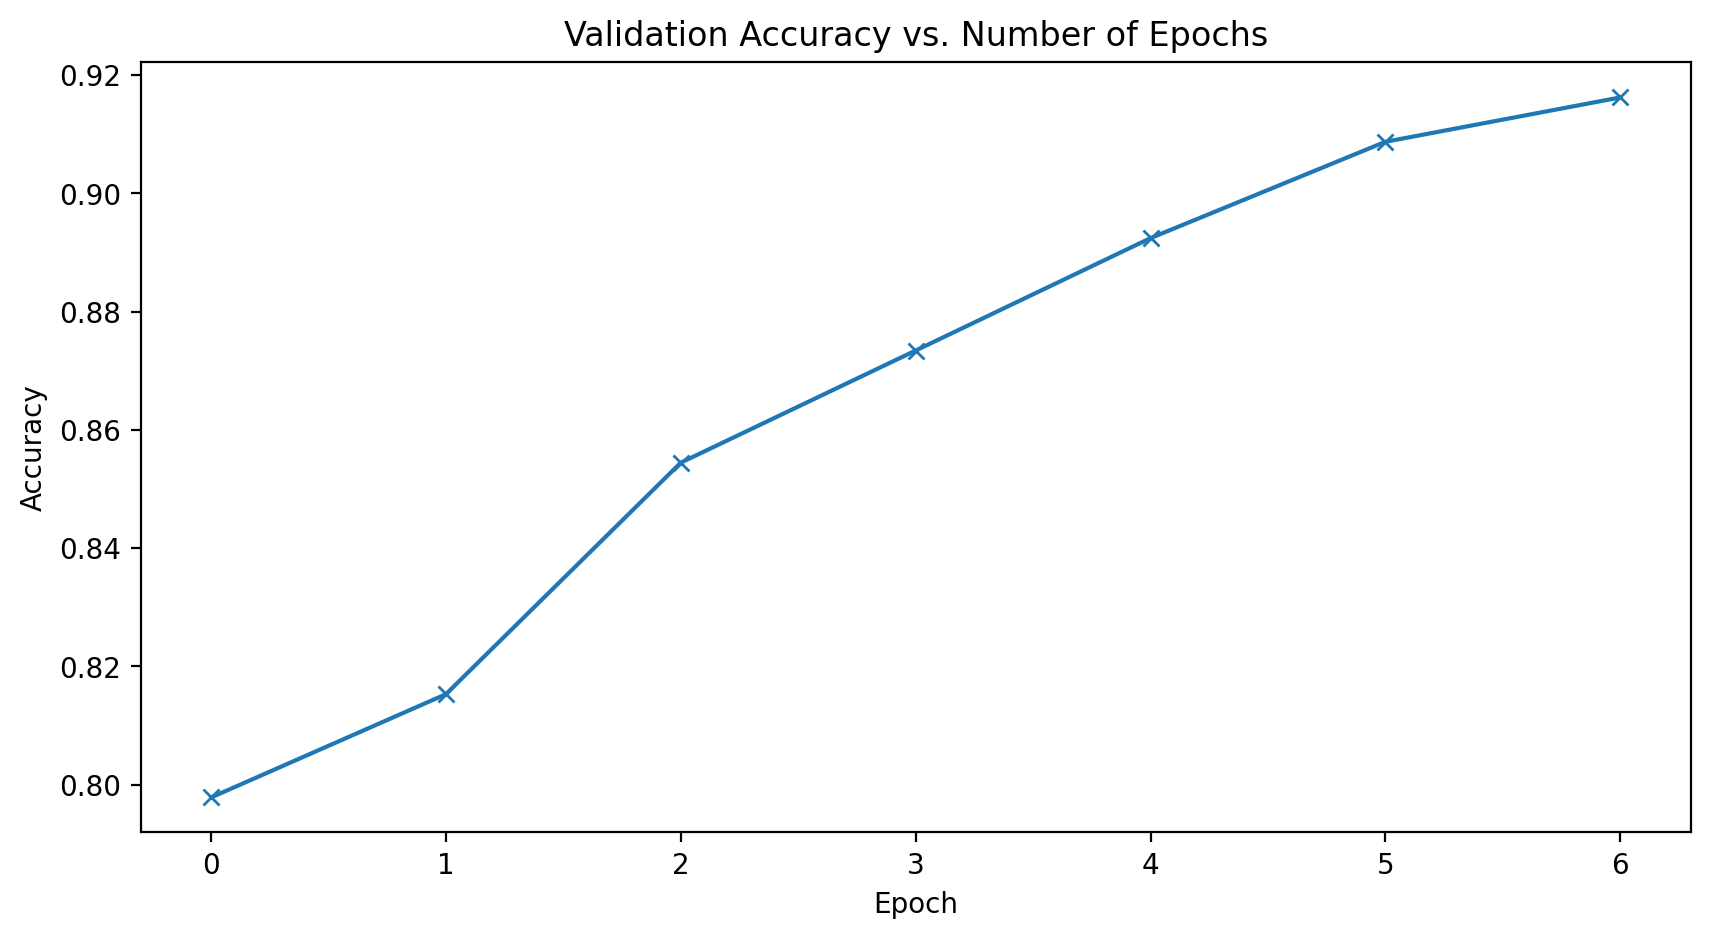

In [21]:
plot_accuracies(history)

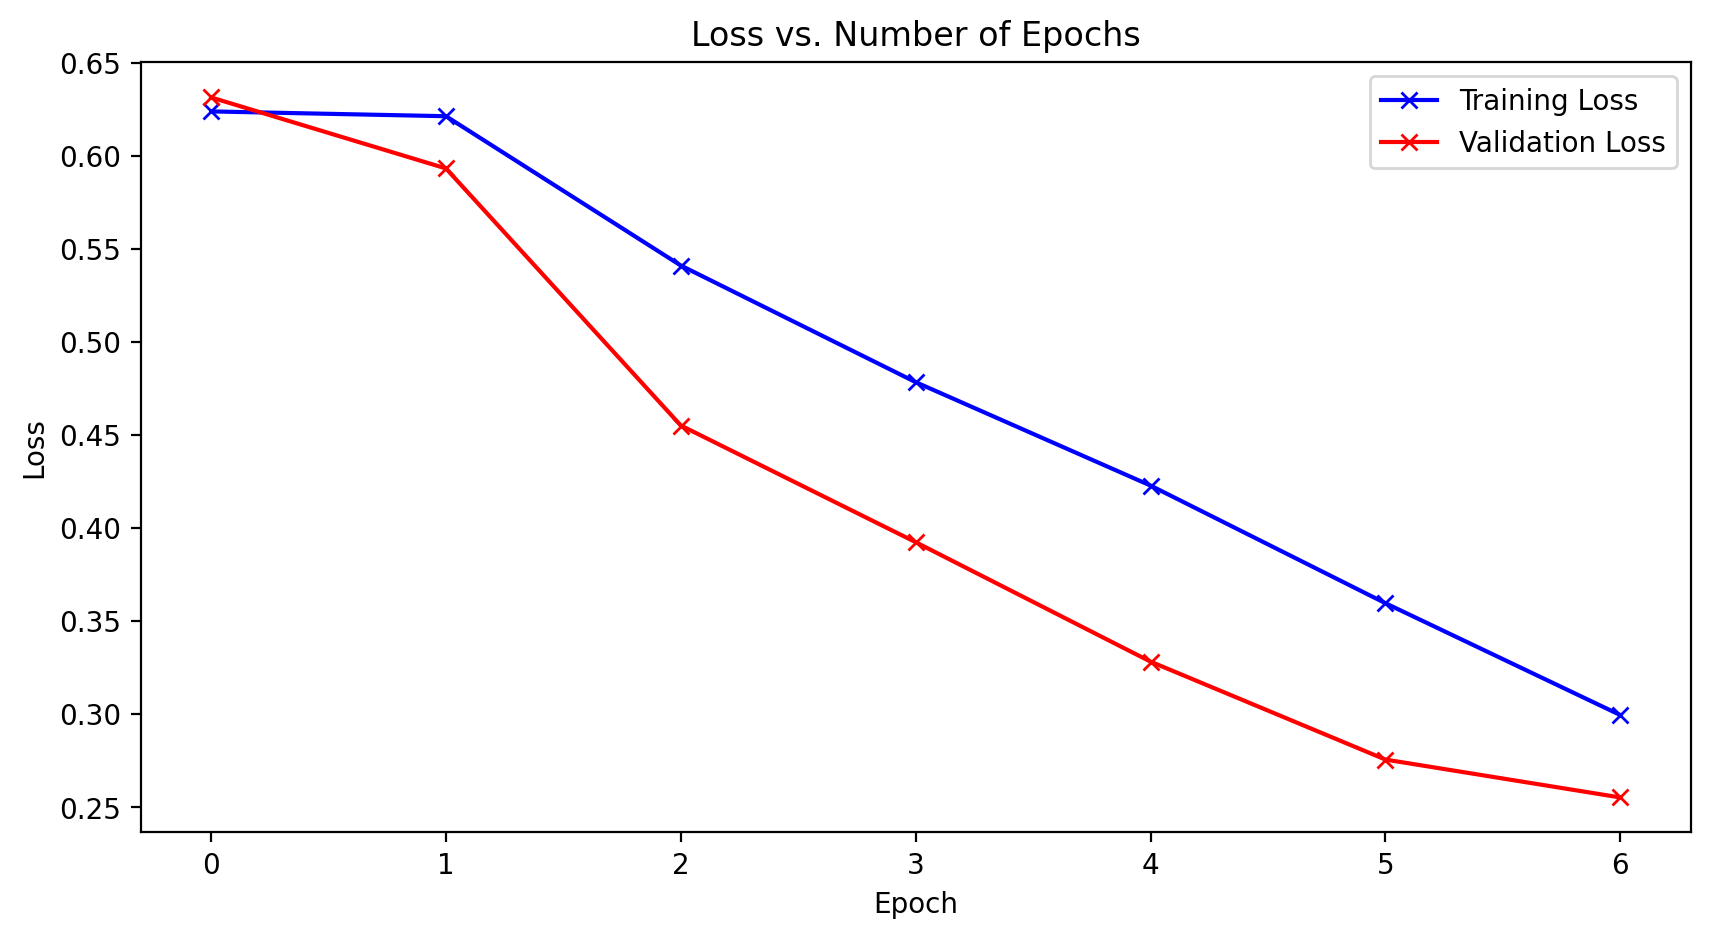

In [22]:
plot_losses(history)

In [25]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path where the data is located (the input directory is read-only)
input_dir = '/kaggle/input/data'  # This is where the original data (images) is stored

# Define the path where we'll save the processed data (the working directory is writable)
working_dir = '/kaggle/working'  # This is where we can store our outputs
test_dir = os.path.join(working_dir, 'test')  # We'll create a 'test' folder here to store test data

# Make sure the 'test' directory exists, or create it if it doesn't
os.makedirs(test_dir, exist_ok=True)

# Set the percentage of data to be used for the test set (80% for training, 20% for testing)
test_size = 0.2  # We're using 20% of images for testing

# Go through each class folder in the input directory
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    
    # Ensure it's a directory (we assume each folder is a class)
    if os.path.isdir(class_path):
        # Get all the image file names in the current class folder
        image_files = os.listdir(class_path)
        
        # Split the list of image files into training and testing sets
        train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)
        
        # Create a subdirectory in the 'test' folder for the current class
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok=True)
        
        # Copy the test images to the 'test' directory we just created
        for test_file in test_files:
            shutil.copy(os.path.join(class_path, test_file), os.path.join(class_test_dir, test_file))

print("Test data has been successfully split and copied to '/kaggle/working/test'.")


Test data has been successfully split and copied to '/kaggle/working/test'.
